In [40]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.optimize import curve_fit
from datetime import datetime
from numba import jit, prange
import scipy.optimize as opt
from gamma_energies import gamma_energies
from calibration import spectrum_calibration

import tables
import os

In [2]:
h5file = tables.open_file("../data/test_input.h5", driver="H5FD_CORE")
print(h5file)
data = h5file.root.RawData
EventData = h5file.root.EventData

h5file2 = tables.open_file("../data/cs137_co60.h5", driver="H5FD_CORE")
print(h5file)
data_CsCo = h5file.root.RawData
EventData_CsCo = h5file.root.EventData

h5file3 = tables.open_file("../data/co57.h5", driver="H5FD_CORE")
print(h5file)
data_Co = h5file.root.RawData
EventData_Co = h5file.root.EventData

h5file4 = tables.open_file("../data/ba133.h5", driver="H5FD_CORE")
print(h5file)
data_Ba = h5file.root.RawData
EventData_Ba = h5file.root.EventData

#h5file5 = tables.open_file("../data/am241.h5", driver="H5FD_CORE")
#print(h5file)
#data_Am = h5file.root.RawData
#EventData_Am = h5file.root.EventData


../data/test_input.h5 (File) ''
Last modif.: 'Sun Sep 30 15:01:08 2018'
Object Tree: 
/ (RootGroup) ''
/EventData (Table(63734,), shuffle, zlib(1)) ''
/RawData (EArray(63734, 4096), shuffle, zlib(1)) ''

../data/test_input.h5 (File) ''
Last modif.: 'Sun Sep 30 15:01:08 2018'
Object Tree: 
/ (RootGroup) ''
/EventData (Table(63734,), shuffle, zlib(1)) ''
/RawData (EArray(63734, 4096), shuffle, zlib(1)) ''

../data/test_input.h5 (File) ''
Last modif.: 'Sun Sep 30 15:01:08 2018'
Object Tree: 
/ (RootGroup) ''
/EventData (Table(63734,), shuffle, zlib(1)) ''
/RawData (EArray(63734, 4096), shuffle, zlib(1)) ''

../data/test_input.h5 (File) ''
Last modif.: 'Sun Sep 30 15:01:08 2018'
Object Tree: 
/ (RootGroup) ''
/EventData (Table(63734,), shuffle, zlib(1)) ''
/RawData (EArray(63734, 4096), shuffle, zlib(1)) ''



In [3]:
# Find pulses that triggered multiple times and delete them
def pileupRM(EventData, data):
    i_pileup = 0
    j_pileup = 0
    pileup_args = np.array([])
    EventDataArray = np.array(EventData)

    for x in range(len(EventData)):
        if int(EventData[x][3])>1:
            pileup_args = np.append(pileup_args,i_pileup)
            j_pileup = j_pileup+1  
        i_pileup = i_pileup+1

    data = np.delete(data[:], pileup_args, 0)
    
    print('deleted ', len(pileup_args),' signals due to pile up')
    return data


In [4]:
data1 = pileupRM(EventData, data)
data2 = pileupRM(EventData_CsCo, data_CsCo)
data3 = pileupRM(EventData_Co, data_Co)
data4 = pileupRM(EventData_Ba, data_Ba)
#data5 = pileupRM(EventData_Am, data_Am)

/Users/DragonKnight/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:14: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
  


deleted  1248  signals due to pile up
deleted  1248  signals due to pile up
deleted  1248  signals due to pile up
deleted  1248  signals due to pile up


In [5]:
@jit(parallel = True)
def baseLineReduction(mysignal):
    avgNoise = np.mean(mysignal[0:1000])
    return mysignal-avgNoise

In [6]:
@jit(parallel = True)
def TrapFilter(mysignal,tau):

    signalOnly = baseLineReduction(mysignal) 

    m=32
    
    #k = peaking time
    #m= Gap time (in samples)
    k=200
    M = tau
    Acc1=0.0
    Acc2=0.0

    i=0
    zeros = np.zeros(2*k+m)
    extSignalOnly=np.append(zeros,signalOnly)
    final = np.zeros(len(signalOnly))
    for i in range(len(signalOnly)):
        parta = extSignalOnly[i+(2*k+m)] - extSignalOnly[i-k+(2*k+m)]
        partb = extSignalOnly[i-2*k-m+(2*k+m)] - extSignalOnly[i-k-m+(2*k+m)]
        partc = parta + partb
        Acc1 = Acc1+partc
        partd = partc*M+Acc1
        Acc2 = Acc2 + partd
        final[i] = Acc2
        i=i+1
    
    normFinal = np.array(final)
    return normFinal

In [7]:
rows = len(data[:,0])
print(rows)
cols = len(data[0,:])
mysignals = np.zeros((rows,cols))

@jit(parallel = True)
def makesignals(raw_data):
    for j in range(0,rows):
        mysignals[j] = data[j,:]
    return mysignals

startTime = datetime.now()

mysignals1 = makesignals(data1)
mysignals2 = makesignals(data2)
mysignals3 = makesignals(data3)
mysignals4 = makesignals(data4)
#mysignals5 = makesignals(data5)

print(datetime.now() - startTime)

63734
0:00:38.602271


In [8]:
@jit(parallel = True)
def func(x, a, b):
    return a * np.exp(-b * x)

In [9]:
@jit(parallel = True)
def eventsProcess(mysignals, events, cols):
    startTime = datetime.now()
    trap_out = np.zeros((events,cols))
    for j in range(0,events):
        trap_out[j] = TrapFilter(mysignals[j,:],5810.8)
    print(datetime.now() - startTime)
    return trap_out

In [10]:
print(len(mysignals))
events = len(mysignals)
trap_out1 = eventsProcess(mysignals1, events, cols)
trap_out2 = eventsProcess(mysignals2, events, cols)
trap_out3 = eventsProcess(mysignals3, events, cols)
trap_out4 = eventsProcess(mysignals4, events, cols)
#trap_out5 = eventsProcess(mysignals5, events, cols)

63734
0:00:18.339475
0:00:20.766446
0:00:17.964007
0:00:18.547788


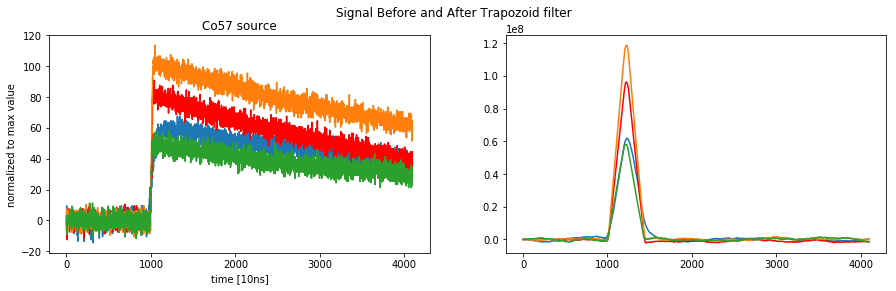

In [102]:
plt.figure(figsize=(15,4))
a_signal1 = baseLineReduction(mysignals3[10][:])
a_signal2 = baseLineReduction(mysignals3[100][:])
a_signal3 = baseLineReduction(mysignals3[1000][:])
a_signal33 = baseLineReduction(mysignals3[50000][:])
a_signal4 = baseLineReduction(mysignals3[10000][:])
#a_signal5 = baseLineReduction(mysignals5[50000][:])

#plt.subplot(231)
#plt.plot(a_signal1[:]/np.amax(a_signal1))
#plt.plot(trap_out1[10][:]/np.amax(trap_out1[10][:]))
#plt.xlabel('time [10ns]')
#plt.ylabel('normalized to max value')
#plt.title('Test Pulse')

#plt.subplot(232)
#plt.plot(a_signal2[:]/np.amax(a_signal2))
#plt.plot(trap_out2[100][:]/np.amax(trap_out2[100][:]))
#plt.xlabel('time [10ns]')
#plt.ylabel('normalized to max value')
#plt.title('Cs137 and Co60 Source')

plt.subplot(121)
plt.plot(a_signal3[:])
plt.plot(a_signal33[:], 'r')
#plt.plot(a_signal1[:])
plt.plot(a_signal2[:])
plt.plot(a_signal4[:])
plt.xlabel('time [10ns]')
plt.ylabel('normalized to max value')
plt.title('Co57 source')

plt.subplot(122)
plt.plot(trap_out3[1000][:])
plt.plot(trap_out3[50000][:], 'r')
#plt.plot(trap_out3[10][:])
plt.plot(trap_out3[100][:])
plt.plot(trap_out3[10000][:])


#plt.subplot(234)
#plt.plot(a_signal4[:]/np.amax(a_signal4))
#plt.plot(trap_out4[10000][:]/np.amax(trap_out4[10000][:]))
#plt.xlabel('time [10ns]')
#plt.ylabel('normalized to max value')
#plt.title('Ba133 Source')

#plt.subplot(235)
#plt.plot(a_signal5[:]/np.amax(a_signal5))
#plt.plot(trap_out5[50000][:]/np.amax(trap_out5[50000][:]))
#plt.xlabel('time [10ns]')
#plt.ylabel('normalized to max value')
#plt.title('Am241 Source')

plt.subplots_adjust(hspace = 1, wspace = 0.2)
plt.suptitle('Signal Before and After Trapozoid filter')
plt.savefig('../images/5signals_3.png')

In [12]:
counts1 = []
for j in range(0,len(trap_out1)):
    counts1 = np.append(counts1,np.amax(trap_out1[j]))
print('counts1 done')    
counts2 = []
for j in range(0,len(trap_out2)):
    counts2 = np.append(counts2,np.amax(trap_out2[j]))
print('counts2 done')    

counts3 = []
for j in range(0,len(trap_out3)):
    counts3 = np.append(counts3,np.amax(trap_out3[j]))
print('counts3 done')    
    
counts4 = []
for j in range(0,len(trap_out4)):
    counts4 = np.append(counts4,np.amax(trap_out4[j]))
print('counts4 done')    
    
#counts5 = []
#for j in range(0,len(trap_out5)):
#    counts5 = np.append(counts5,np.amax(trap_out5[j]))

counts1 done
counts2 done
counts3 done
counts4 done


In [74]:
@jit(parallel = True)
def createHist(counts,k,M, upperlim):
    counts2 = np.trim_zeros(counts)
#    counts2 = counts2/((M+1)*k)
    counts3 = counts2[(counts2>0) & (counts2<upperlim)]
#    counts3 = counts3/((M+1)*k)

    yhist, bins_hist = np.histogram(counts3,bins=8196)
    return yhist

k=740.0
M = 5810.8

yhist1 = createHist(counts1,k,M,1.5e9)
yhist2 = createHist(counts2,k,M,1e9)
yhist3 = createHist(counts3,k,M,1e9)
#yhist4 = createHist(counts4,k,M,1e9)
#yhist5 = createHist(counts5,k,M,5.7e2)



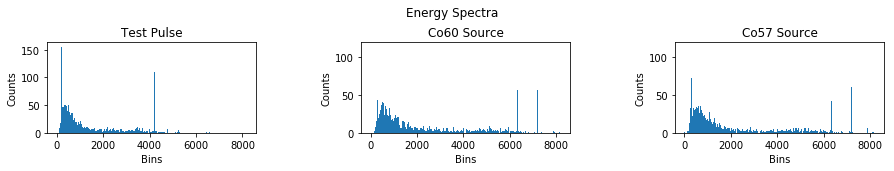

In [75]:
plt.figure(figsize=(15,5))

plt.subplot(231)
plt.bar(range(8196),yhist1, width=1.0)
plt.xlabel('Bins')
plt.ylabel('Counts')
plt.title('Test Pulse')
#plt.ylim(0,100)
#plt.xlim(3000,3300)

plt.subplot(232)
plt.bar(range(8196),yhist2, width=1.0)
plt.xlabel('Bins')
plt.ylabel('Counts')
plt.title('Co60 Source')
#plt.ylim(0,300)
#plt.xlim(0,4000)

plt.subplot(233)
plt.bar(range(8196),yhist3, width=1.0)
plt.xlabel('Bins')
plt.ylabel('Counts')
plt.title('Co57 Source')
#plt.ylim(0,300)
#plt.xlim(0,4000)

#plt.subplot(234)
#plt.bar(range(8196),yhist4, width=1.0)
#plt.xlabel('Bins')
#plt.ylabel('Counts')
#plt.title('Ba133 Source')
#plt.ylim(0,300)
#plt.xlim(0,4000)

#plt.subplot(235)
#plt.bar(range(8196),yhist5, width=1.0)
#plt.xlabel('Bins')
#plt.ylabel('Counts')
#plt.title('Am241 Source')
#plt.xlim(0,5000)

plt.subplots_adjust(hspace = 1, wspace = 0.5)
plt.suptitle('Energy Spectra')
plt.savefig('../images/BinnedData_3.png')

In [76]:
plt.close()
print(gamma_energies('57Co'))
print(gamma_energies('60Co'))
print(gamma_energies('137Cs'))
print(gamma_energies('133Ba'))
print(gamma_energies('241Am'))

energy_list1 = gamma_energies('57Co')
energy_list2 = gamma_energies('60Co')
energy_list  = [energy_list1[2], energy_list2[0],energy_list2[1]]
print(energy_list)

[14.41295, 122.06065, 136.47356]
[1173.228, 1332.492]
[661.657]
[53.1622, 80.9979, 276.3989, 302.8508, 356.0129, 383.8485]
[59.5409]
[136.47356, 1173.228, 1332.492]


In [86]:
def gauss(x, a, u, sig): # p[0]==mean, p[1]==stdev
#    return 1.0/(sig*np.sqrt(2.0*np.pi))*np.exp(-(x-u)**2.0/(2.0*sig**2.0))
    return a*np.exp(-(x-u)**2.0/(2.0*sig**2.0))

def FWHM(counts,lower_bound,upper_bound):
    X = range(lower_bound, upper_bound)
    Y = counts[lower_bound:upper_bound]
    # Fit a guassian
    mean = sum(X * Y) / sum(Y)
    sigma = np.sqrt(sum(Y * (X - mean)**2) / sum(Y))
    print(sigma)
    pi = [max(Y), mean,sigma]
    popt, pcov = curve_fit(gauss, X, Y, p0=pi)
    print(popt)
    fit_a, fit_mu, fit_stdev = popt
    plt.figure()
    plt.plot(X,gauss(X,*popt),'r')
    plt.bar(X,Y, width=1.0)
    plt.xlim(lower_bound,upper_bound)

    return 2*np.sqrt(2*np.log(2))*np.abs(fit_stdev)
#    return

11.951254777284696
[ 85.81053725 306.49660584  12.3853331 ]
140.72138310146724
[  65.86927849 6327.60981108    8.53591643]
15.339487334943389
[  56.03957055 7191.79271412    8.80842205]


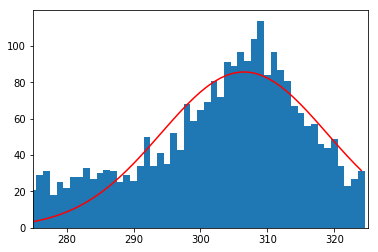

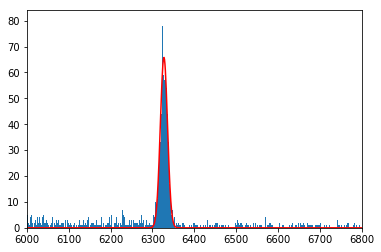

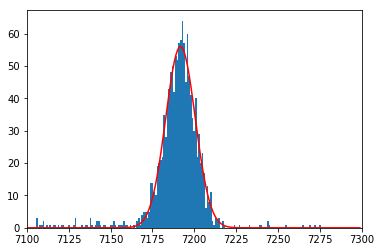

In [87]:
a = FWHM(yhist3,275,325)
b = FWHM(yhist3,6000,6800)
c = FWHM(yhist3,7100,7300)


In [105]:
u    = np.zeros(3)
sig  = np.zeros(3)

u[0]= 306.5
u[1]= 6327.61
u[2]= 7191.79

fwhm_1a = 85.81
fwhm_1b = 65.86
fwhm_1c = 56.03
ER1 = np.zeros(3)

ER1[0] = fwhm_1a/u[0]
ER1[1] = fwhm_1b/u[1]
ER1[2] = fwhm_1c/u[2]

print(ER1)

def linear(x,a,b):
    return a*x+b

popt, pcov = curve_fit(linear,u,energy_list)
print(popt)

[0.27996737 0.01040835 0.00779083]
[ 0.17314728 82.75887927]


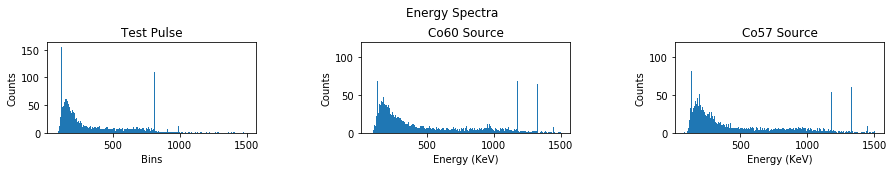

In [93]:
plt.figure(figsize=(15,5))

x_energy = linear(range(8196),popt[0],popt[1])

plt.subplot(231)
plt.bar(x_energy,yhist1, width=1.0)
plt.xlabel('Bins')
plt.ylabel('Counts')
plt.title('Test Pulse')
#plt.ylim(0,100)
#plt.xlim(3000,3300)

plt.subplot(232)
plt.bar(x_energy,yhist2, width=1.0)
plt.xlabel('Energy (KeV)')
plt.ylabel('Counts')
plt.title('Co60 Source')
#plt.ylim(0,300)
#plt.xlim(0,4000)

plt.subplot(233)
plt.bar(x_energy,yhist3, width=1.0)
plt.xlabel('Energy (KeV)')
plt.ylabel('Counts')
plt.title('Co57 Source')
#plt.ylim(0,300)
#plt.xlim(0,4000)

#plt.subplot(234)
#plt.bar(range(8196),yhist4, width=1.0)
#plt.xlabel('Bins')
#plt.ylabel('Counts')
#plt.title('Ba133 Source')
#plt.ylim(0,300)
#plt.xlim(0,4000)

#plt.subplot(235)
#plt.bar(range(8196),yhist5, width=1.0)
#plt.xlabel('Bins')
#plt.ylabel('Counts')
#plt.title('Am241 Source')
#plt.xlim(0,5000)

plt.subplots_adjust(hspace = 1, wspace = 0.5)
plt.suptitle('Energy Spectra')
plt.savefig('../images/BinnedData_3_energy.png')